In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pickle
import json
import numpy as np
import ast
from wordcloud import WordCloud
import infomap
import shutil
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

In [ ]:
G_weighted = pickle.load(open("Data\\G_weighted_largest_component.pickle", "rb"))
verified = json.load(open('Data\\ser_data_verified', 'r'))
username = json.load(open('Data\\user_data_username', 'r'))
days_of_collection = json.load(open('Data\\day_dict', 'r'))
user_text_data_misinf2 = pd.read_csv('Data\\cleaned_user_text_data_misinf2.csv', usecols=[2,3,4])
user_text_data_misinf2['Number_of_tweets'] = [len(ast.literal_eval(tweets)) for tweets in user_text_data_misinf2['Cleaned_Tweets']]
edges_table = pd.read_csv("Data\\user_retweet_network_data_full.csv")
sorted_communities_louvain = pickle.load(open('Data\\base_louvain_sorted_communities.pickle', 'rb'))

# Data overview

In [ ]:
average_tweets_per_original_account = np.mean([len(ast.literal_eval(tweets)) for tweets in user_text_data_misinf2['Cleaned_Tweets']])
print(average_tweets_per_original_account)

In [ ]:
plt.style.use("seaborn")
plt.plot(days_of_collection.keys(), days_of_collection.values())
plt.xticks([0,4,9,14,19,24,30])
plt.xlabel('Day of collection')
plt.ylabel('Number of posts')
plt.savefig("D:\\M4R_oskar\\Figures\\tweets_over_time.png", bbox_inches='tight')

In [ ]:
# wordcloud for dataset
text = " ".join(str(ast.literal_eval(user_text_data_misinf2['Cleaned_Tweets'][i])) for i in range(len(user_text_data_misinf2['Cleaned_Tweets']))) # all text from all tweets
cloud = WordCloud(collocations=False, background_color='white').generate(text)  # generate wordcloud
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Misinformation classification

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')  # input
  preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='preprocessing')  # preprocessing
  encoder_inputs = preprocessing_layer(text_input)  # preprocessed inputs to the encoder
  encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1', trainable=True, name='BERT_encoder')  # encoder
  outputs = encoder(encoder_inputs)  # run through BERT model
  net = outputs['pooled_output'] # output of BERT encoder
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)  # classification layer
  return tf.keras.Model(text_input, net)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # loss function used
metrics = tf.metrics.BinaryAccuracy()  # accuracy metric

## Hyperparameter tuning

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)  # set early stopping criterion

epochs = 25

learning_rate_list = [0.001, 0.0005, 0.0001]
batch_size_list = [16, 32, 64, 128, 256]

for rate in learning_rate_list:
  # search over learning rates
  for size in batch_size_list:
    #search over batch size
    tf.random.set_seed(12345)

    batch_size = size
    init_lr = rate

    AUTOTUNE = tf.data.AUTOTUNE
    # training and validation datasets
    train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

    train_val_data.shuffle(buffer_size=len(list(train_val_data)))  # shuffle dataset

    train_val_set_size = len(list(train_val_data))
    val_n = int(0.2*train_val_set_size)  # size of validation set

    train_data = train_val_data.skip(val_n).batch(batch_size)
    train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)  # prefetch for faster training
    val_data = train_val_data.take(val_n).batch(batch_size)
    val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)  # prefetch for faster training

    steps_per_epoch = train_val_set_size - val_n
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)  # warmup steps
    # initialize optimizer
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                             num_train_steps=num_train_steps,
                                             num_warmup_steps=num_warmup_steps,
                                             optimizer_type='adamw')

    classifier = build_classifier_model()  # initialize model
    #compile and fit
    classifier.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)
    history = classifier.fit(x=train_data, validation_data=val_data, epochs=epochs, callbacks=[early_stopping])
    history_dict=history.history
    print(f"Learning rate {rate}, Batch size {size}")
    print(history_dict['loss'])
    print(history_dict['val_loss'])
    print(history_dict['binary_accuracy'])
    print(history_dict['val_binary_accuracy'])

## Final model

In [ ]:
tf.random.set_seed(12345)

epochs = 25

batch_size = 16
init_lr = 0.001

AUTOTUNE = tf.data.AUTOTUNE
# training and validation dataset
train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32], select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)))
train_val_set_size = len(list(train_val_data))
val_n = int(0.2*train_val_set_size)

train_data = train_val_data.skip(val_n).batch(batch_size)
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = train_val_data.take(val_n).batch(batch_size)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

steps_per_epoch = train_val_set_size - val_n
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

final_classifier = build_classifier_model()
final_classifier.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)
history = final_classifier.fit(x=train_data, validation_data=val_data, epochs=7)

final_classifier.save_weights('final_classifier8')

Epoch 1/7
458/458 [==============================] - 39s 66ms/step - loss: 0.3965 - binary_accuracy: 0.8378 - val_loss: 0.1721 - val_binary_accuracy: 0.9366
Epoch 2/7
458/458 [==============================] - 31s 68ms/step - loss: 0.1663 - binary_accuracy: 0.9406 - val_loss: 0.1181 - val_binary_accuracy: 0.9656
Epoch 3/7
458/458 [==============================] - 31s 68ms/step - loss: 0.1149 - binary_accuracy: 0.9653 - val_loss: 0.1293 - val_binary_accuracy: 0.9716
Epoch 4/7
458/458 [==============================] - 31s 68ms/step - loss: 0.0975 - binary_accuracy: 0.9739 - val_loss: 0.1148 - val_binary_accuracy: 0.9732
Epoch 5/7
458/458 [==============================] - 32s 69ms/step - loss: 0.0834 - binary_accuracy: 0.9784 - val_loss: 0.1393 - val_binary_accuracy: 0.9716
Epoch 6/7
458/458 [==============================] - 31s 68ms/step - loss: 0.0684 - binary_accuracy: 0.9821 - val_loss: 0.1381 - val_binary_accuracy: 0.9705
Epoch 7/7
458/458 [==============================] - 31s 6

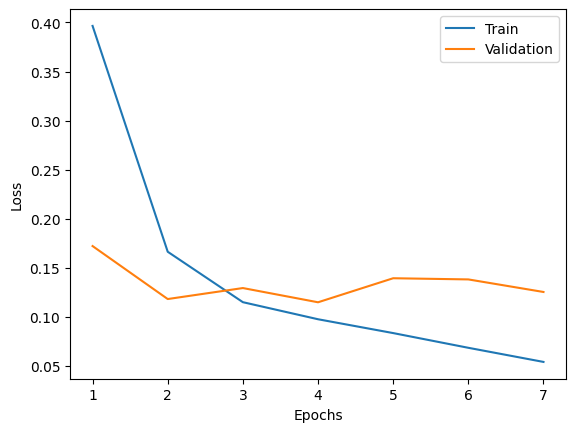

In [ ]:
train_loss = [0.3965, 0.1663, 0.1149, 0.0975, 0.0834, 0.0684, 0.0540]
validation_loss = [0.1721, 0.1181, 0.1293, 0.1148, 0.1393, 0.1381, 0.1253]

import matplotlib.pyplot as plt
plt.plot(range(1,8), train_loss, label='Train')
plt.plot(range(1,8), validation_loss , label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Loss_graph')

In [ ]:
model = build_classifier_model()
model.load_weights('Data\\final_classifier8')

In [ ]:
test_data = tf.data.experimental.CsvDataset(["test_bert"], [tf.string,tf.int32] ,select_cols=[2,3])
test_data = test_data.batch(batch_size)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.evaluate(test_data)  # final validation loss and accuracy

143/143 [==============================] - 5s 34ms/step - loss: 0.1724 - binary_accuracy: 0.9733


[0.1724161058664322, 0.9732879996299744]

### ROC Curve

---



In [ ]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

test_df = pd.read_csv('D:\\Downloads\\test_df')

true_labels = test_df['Misinformation']
predicted_labels = test_df['Prediction_proba']

fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='red', label='Random classifier line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('D:\\M4R_oskar\\Figures\\ROC_curve.png')
plt.show()

In [ ]:
threshold = thresholds[np.argmax(tpr - fpr)]  # optimal threshold
print(threshold)

### k-fold cross validation

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
# training and validation dataset
train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32], select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)), seed = 12345)

train_val_set_size = len(list(train_val_data))

split_size = int(0.2*train_val_set_size)

batch_size = 16

# prepare folds for cross validation

cv_1 = train_val_data.take(split_size).batch(batch_size)
cv_1 = cv_1.cache().prefetch(buffer_size=AUTOTUNE)
m1 = train_val_data.skip(split_size)
cv_2 = m1.take(split_size).batch(batch_size)
cv_2 = cv_2.cache().prefetch(buffer_size=AUTOTUNE)
m2 = m1.skip(split_size)
cv_3 = m2.take(split_size).batch(batch_size)
cv_3 = cv_3.cache().prefetch(buffer_size=AUTOTUNE)
m3 = m2.skip(split_size)
cv_4 = m3.take(split_size).batch(batch_size)
cv_4 = cv_4.cache().prefetch(buffer_size=AUTOTUNE)
cv_5 = m3.skip(split_size).batch(batch_size)
cv_5 = cv_5.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
acc_fold = []
val_acc_fold = []
loss_fold = []
val_loss_fold = []

init_lr = 0.001
epochs = 25

steps_per_epoch = train_val_set_size - split_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)


# fold 1
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv1 = build_classifier_model()
classifier_model_cv1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv1 = classifier_model_cv1.fit(x=cv_2.concatenate(cv_3).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_1,
                               epochs=7)
history_dict_cv1 = history_cv1.history

acc_fold.append(history_dict_cv1['binary_accuracy'])
val_acc_fold.append(history_dict_cv1['val_binary_accuracy'])
loss_fold.append(history_dict_cv1['loss'])
val_loss_fold.append(history_dict_cv1['val_loss'])

# fold 2
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv2 = build_classifier_model()
classifier_model_cv2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv2 = classifier_model_cv2.fit(x=cv_1.concatenate(cv_3).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_2,
                               epochs=7)
history_dict_cv2 = history_cv2.history

acc_fold.append(history_dict_cv2['binary_accuracy'])
val_acc_fold.append(history_dict_cv2['val_binary_accuracy'])
loss_fold.append(history_dict_cv2['loss'])
val_loss_fold.append(history_dict_cv2['val_loss'])

#fold 3
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv3 = build_classifier_model()
classifier_model_cv3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv3 = classifier_model_cv3.fit(x=cv_2.concatenate(cv_1).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_3,
                               epochs=7)
history_dict_cv3 = history_cv3.history

acc_fold.append(history_dict_cv3['binary_accuracy'])
val_acc_fold.append(history_dict_cv3['val_binary_accuracy'])
loss_fold.append(history_dict_cv3['loss'])
val_loss_fold.append(history_dict_cv3['val_loss'])

# fold 4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv4 = build_classifier_model()
classifier_model_cv4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv4 = classifier_model_cv4.fit(x=cv_2.concatenate(cv_3).concatenate(cv_1).concatenate(cv_5),
                               validation_data=cv_4,
                               epochs=7)
history_dict_cv4 = history_cv4.history

acc_fold.append(history_dict_cv4['binary_accuracy'])
val_acc_fold.append(history_dict_cv4['val_binary_accuracy'])
loss_fold.append(history_dict_cv4['loss'])
val_loss_fold.append(history_dict_cv4['val_loss'])

#fold 5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv5 = build_classifier_model()
classifier_model_cv5.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv5 = classifier_model_cv5.fit(x=cv_2.concatenate(cv_3).concatenate(cv_4).concatenate(cv_1),
                               validation_data=cv_5,
                               epochs=7)
history_dict_cv5 = history_cv5.history

acc_fold.append(history_dict_cv5['binary_accuracy'])
val_acc_fold.append(history_dict_cv5['val_binary_accuracy'])
loss_fold.append(history_dict_cv5['loss'])
val_loss_fold.append(history_dict_cv5['val_loss'])

# print
print(acc_fold)
print(val_acc_fold)
print(loss_fold)
print(val_loss_fold)

Epoch 1/7
232/232 [==============================] - 44s 139ms/step - loss: 0.5045 - binary_accuracy: 0.7518 - val_loss: 0.2938 - val_binary_accuracy: 0.8721
Epoch 2/7
232/232 [==============================] - 30s 130ms/step - loss: 0.2439 - binary_accuracy: 0.9002 - val_loss: 0.1527 - val_binary_accuracy: 0.9497
Epoch 3/7
232/232 [==============================] - 32s 138ms/step - loss: 0.1458 - binary_accuracy: 0.9471 - val_loss: 0.1106 - val_binary_accuracy: 0.9656
Epoch 4/7
232/232 [==============================] - 30s 130ms/step - loss: 0.1032 - binary_accuracy: 0.9679 - val_loss: 0.1149 - val_binary_accuracy: 0.9694
Epoch 5/7
232/232 [==============================] - 32s 137ms/step - loss: 0.0903 - binary_accuracy: 0.9728 - val_loss: 0.1109 - val_binary_accuracy: 0.9716
Epoch 6/7
232/232 [==============================] - 30s 130ms/step - loss: 0.0714 - binary_accuracy: 0.9779 - val_loss: 0.1230 - val_binary_accuracy: 0.9678
Epoch 7/7
232/232 [==============================] -

### Test set performance

In [ ]:
# predicted labels misinf if output of sigmoid over threshold
pred_labels = test_df['Prediction_proba'].apply(lambda x: 1 if x > threshold else 0)
print(confusion_matrix(true_labels, pred_labels))

In [ ]:
print(confusion_matrix(true_labels, pred_labels))
print(accuracy_score(true_labels, pred_labels))
print(precision_score(true_labels, pred_labels))
print(recall_score(true_labels, pred_labels))
print(f1_score(true_labels, pred_labels))

### BERT applied to collected dataset

predict misinformation for cleaned tweets and pass through model


In [ ]:
df = pd.read_csv('cleaned_user_text_data.csv')  # dataset with cleaned tweet text
df['Misinformation'] = np.nan

threshold = 0.0034709275

print(len(df))  # 119813 users tweeting original tweets

for index, tweets in enumerate(df['Cleaned_Tweets']):
  if index % 1000 == 0:
    print(index)
  tweets = ast.literal_eval(tweets)
  prediction_sigmoid = tf.sigmoid(model(tf.constant(tweets)))  # sigmoid outputs
  n_misinf = 0
  for prediction in prediction_sigmoid:
    if float(prediction) > threshold:
      n_misinf += 1
  quotient = n_misinf/len(tweets)  # misinformation quotient
  df['Misinformation'].iloc[index] = quotient

df.to_csv('cleaned_user_text_data_misinf2.csv')


Find total misinf in network

In [ ]:
n_info = 0
n_misinfo = 0

for i in range(len(user_text_data_misinf2)):
  # loop over all original users in network
  n = user_text_data_misinf2['Number_of_tweets'].iloc[i]
  misinf_quotient = user_text_data_misinf2['Misinformation'].iloc[i]
  n_info += (1-misinf_quotient) * n
  n_misinfo += misinf_quotient * n

print(n_info)
print(n_misinfo)


141965.0
98877.0


# Create user retweet network

multiple edges between nodes

In [ ]:
G_multi = nx.MultiDiGraph() # multi-edge graph of network

for i in range(len(edges_table)):
  G_multi.add_edge(edges_table['Source'][i], edges_table['Target'][i])


In [ ]:
G_weighted = nx.DiGraph()  # weighted graph of network from multi-edge graph

for source, target in G_multi.edges():
  if G_weighted.has_edge(source, target):
    # if edge exists add one weight
    G_weighted[source][target]['weight'] += 1
  else:
    # if edge does not exist add it
    G_weighted.add_edge(source, target, weight= 1)

# Degree analysis

In [ ]:
degree_list = [degree for id, degree in G_weighted.degree()]
degree_list_weighted = [degree for id, degree in G_weighted.degree(weight='weight')]
in_degree_list_weighted = [degree for id, degree in G_weighted.in_degree(weight='weight')]
out_degree_list_weighted = [(id, degree) for id, degree in G_weighted.out_degree(weight='weight')]

## Find ids of 10 most influential nodes.

In [ ]:
most_influential_users = [(id, degree) for id, degree in G_weighted.in_degree(weight='weight')]  # list of id and degree
most_influential_users = sorted(most_influential_users, key=lambda x:x[1], reverse=True)  # sort
in_degree_user_rank = [id for id, degree in most_influential_users]
highest_indegree_users_100 = [id for id, degree in most_influential_users[0:100]]

In [ ]:
for i in range(10):
    user_id = most_influential_users[i][0]
    index = user_text_data_misinf2.index[user_text_data_misinf2['User_ID'] == user_id].tolist()[0]
    print(username[str(user_id)])
    print(most_influential_users[i][1])
    print(user_text_data_misinf2['Misinformation'][index])

In [ ]:
unique_degree_dict = {}  # dict with unique degrees and number of nodes having that degree

for degree in degree_list_weighted:
  if degree not in unique_degree_dict:
    unique_degree_dict[degree] = 1
  else:
    unique_degree_dict[degree] += 1

unique_degree_list = sorted(unique_degree_dict.items(), key=lambda x:x[0])

In [ ]:
unique_degree_list = sorted(unique_degree_list, key=lambda x:x[1], reverse=True)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(*zip(*unique_degree_list))
ax.grid()
ax.set_xlabel("Degree")
ax.set_ylabel("Count")
ax.set_yscale("log")
ax.set_xscale("log")
fig.savefig("loglog_degree.png", dpi=300, bbox_inches='tight')  # loglog plot of degree count

In [ ]:
with open('D:\\M4R_oskar\\User_Network\\G_weighted_largest_component.pickle', 'rb') as fp:
    G_weighted = pickle.load(fp)

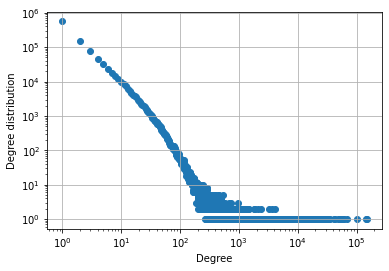

In [ ]:
unique_degree_dict_unweighted = {}  # dict with unique degrees and number of nodes having that degree

for degree in degree_list:
  if degree not in unique_degree_dict_unweighted:
    unique_degree_dict_unweighted[degree] = 1
  else:
    unique_degree_dict_unweighted[degree] += 1

unique_degree_list_unweighted = sorted(unique_degree_dict_unweighted.items(), key=lambda x:x[0])  # sort according to the value of key

fig, ax = plt.subplots()

ax.scatter(*zip(*unique_degree_list_unweighted))
ax.grid()
ax.set_xlabel("Degree")
ax.set_ylabel("Degree distribution")
ax.set_yscale("log")
ax.set_xscale("log")
fig.savefig("loglog_degree.png", dpi=300, bbox_inches='tight')

# Log binning

In [ ]:
degree_distribution = [dist[1] for dist in unique_degree_list_unweighted]
degree_list = [dist[0] for dist in unique_degree_list_unweighted]

In [ ]:
log_bins = np.logspace(np.log10(min(degree_list)), np.log10(max(degree_list)), 10)  # log spaced bins

In [ ]:
binned_distribution = []
binned_degree = []

for i in range(len(log_bins)-1):
    # loop over all bins to populate them
    nodes_in_bin = 0
    total_degree = 0
    total_bin_distribution = 0
    bin_size = int(log_bins[i+1] - log_bins[i])

    for j in range(len(degree_list)):
        # loop over all degree values to see if they are in this bin

        degree = degree_list[j]
        nodes_degree = degree_distribution[j]

        if degree >= log_bins[i] and degree < log_bins[i+1]:
            # if degree is in bin
            # then all nodes with that degree are in this bin
            total_bin_distribution += degree_distribution[j]

            nodes_in_bin += degree_distribution[j]

            total_degree += degree*degree_distribution[j]

    binned_degree.append(total_degree/nodes_in_bin) # append average degree in bin

    binned_distribution.append(total_bin_distribution/bin_size)


In [ ]:
# create new unique_degree_list_unweighted where the counts are divided by the total number of nodes
unique_degree_list_unweighted2 = [(degree, count/total_number_of_nodes) for degree, count in unique_degree_list_unweighted]

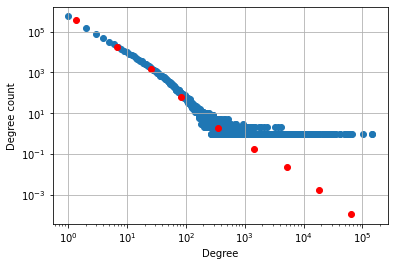

In [ ]:
fig, ax = plt.subplots()

ax.scatter(*zip(*unique_degree_list_unweighted))
ax.scatter(binned_degree, binned_distribution, color='r')
ax.grid()
ax.set_xlabel("Degree")
ax.set_ylabel("Degree count")
ax.set_yscale("log")
ax.set_xscale("log")
fig.savefig("D:\\M4R_oskar\\Figures\\loglog_degree_log_binned.png", dpi=300, bbox_inches='tight')

# In degree plot

In [ ]:
unique_in_degree_dict = {}  # dict with unique degrees and number of nodes having that degree

for degree in in_degree_list_weighted:
  if degree not in unique_in_degree_dict:
    unique_in_degree_dict[degree] = 1
  else:
    unique_in_degree_dict[degree] += 1

unique_in_degree_list = sorted(unique_in_degree_dict.items(), key=lambda x:x[0])  # sort according to the value of key


In [ ]:
sum_counts_in = 0  # total in_degree
for i in range(len(unique_in_degree_list)):
    sum_counts_in += unique_in_degree_list[i][1]

print(sum_counts_in)

for i in range(len(unique_in_degree_list)):
    unique_in_degree_list[i] = (unique_in_degree_list[i][0], unique_in_degree_list[i][1]/sum_counts_in)  # in-degree distribution

1034337


In [ ]:
fig, ax = plt.subplots()

ax.scatter(*zip(*unique_in_degree_list))
ax.grid()
ax.set_xlabel("In-Degree")
ax.set_ylabel("Count")
ax.set_yscale("log")
ax.set_xscale("log")
fig.savefig("loglog_in_degree.png", dpi=300, bbox_inches='tight')

# Out degree plot

In [ ]:
unique_out_degree_dict = {}  # out-degree dict with count of nodes with that degree

for degree in out_degree_list_weighted:
  if degree not in unique_out_degree_dict:
    unique_out_degree_dict[degree] = 1
  else:
    unique_out_degree_dict[degree] += 1

unique_out_degree_list = sorted(unique_out_degree_dict.items(), key=lambda x:x[1], reverse=True)  # sort according to the value of key

In [ ]:
sum_counts_out = 0 # total out-degree
for i in range(len(unique_out_degree_list)):
    sum_counts_out += unique_out_degree_list[i][1]

for i in range(len(unique_out_degree_list)):
    unique_out_degree_list[i] = (unique_out_degree_list[i][0], unique_out_degree_list[i][1]/sum_counts_out)


1034337


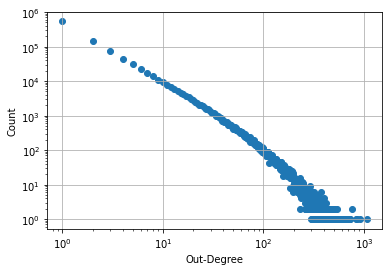

In [ ]:
fig, ax = plt.subplots()

ax.scatter(*zip(*unique_out_degree_list))
ax.grid()
ax.set_xlabel("Out-Degree")
ax.set_ylabel("Count")
ax.set_yscale("log")
ax.set_xscale("log")
fig.savefig("loglog_out_degree.png", dpi=300, bbox_inches='tight')

# Pagerank for entire network

In [ ]:
pagerank = nx.pagerank(G_weighted, weight='weight')

In [ ]:
pagerank_values = [pagerank_tuple[1] for pagerank_tuple in pagerank_list]

In [ ]:
misinf_quotient_pagerank_10_highest = []

for i in range(10):
    user_id = pagerank_list[i][0]
    index = user_text_data_misinf2.index[user_text_data_misinf2['User_ID'] == user_id].tolist()[0]
    print(username[str(user_id)])
    print(pagerank_list[i][1])
    print(user_text_data_misinf2['Misinformation'][index])
    print(user_text_data_misinf2['Cleaned_Tweets'][index])
    misinf_quotient_pagerank_10_highest.append(user_text_data_misinf2['Misinformation'][index])

Project_Veritas
0.047067411193383216
0.6153846153846154
['In we released videos within an ER room - a nurse recorded a doctor raising concerns about Covid-19 vax &amp; associated heart complications"Government doesn\'t want to show that the darn vaccine is full of shit!"[He] probably has myocarditis due to the vaccine!"', 'The reveal that COVID-19 natural immunity was being censored on social media.You might recall when we caught a scientist saying your antibodies are better than their vax. Your [COVID] antibodies are probably better than the [Pfizer] vaccination.', "Big Pharma has long known of potential Covid-19 vaccine side effects...They just didn't want to say so publicly.In scientist Chris Croce told our journalist that they were already testing for links between their vaccine and myocarditis...What did find?", 'Jan : Chris Cole Exec foreshadowed notorious annual booster shots of the COVID-19 Vaccine, even for toddlers." wants to inoculate as many people as possible.""It is impor

In [ ]:
print(np.mean(misinf_quotient_pagerank_10_highest))

0.4965420985633752


## Spearman correlation of PageRank with In-Degree

In [ ]:
pagerank_list = sorted(list(pagerank.items()), key=lambda x: x[1], reverse=True)

ordered_pagerank = [user[0] for user in pagerank_list]  # list of users ordered by PageRank

in_degree_ranks = []  # top 100 in-degree nodes ranked by indegree
pagerank_ranks = []  # top 100 in-degree nodes ranked by pagerank

for i in range(100):
    user_id = in_degree_user_rank[i]  # user id of i+1 ranked node by in degree
    in_degree_ranks.append(i+1)
    pagerank_ranks.append(ordered_pagerank.index(user_id)+1)  # append pagerank of i+1 ranked node by indegree


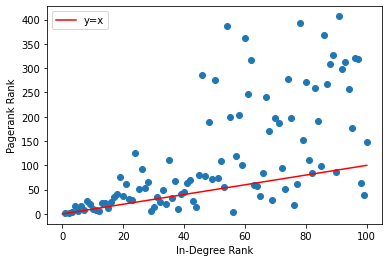

In [ ]:
plt.scatter(in_degree_ranks, pagerank_ranks)
plt.plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100), color='r', label='y=x')  # to show scale
plt.legend(loc = 'upper left')
plt.xlabel("In-Degree Rank")
plt.ylabel("Pagerank Rank")
plt.savefig("D:\\M4R_oskar\\Figures\\in_degree_pagerank_rank.png", dpi=300, bbox_inches='tight')

In [ ]:
import scipy.stats as stats

# value of spearman statistic for observed data
rho, p_value = stats.spearmanr(pagerank_ranks,in_degree_ranks)

print(rho)

### Permutation test

In [ ]:
n = 10000  # permutation test iterations

rhos = []

for i in range(n):
    permuted_pagerank_ranks = np.random.permutation(pagerank_ranks)  # permute pageranks
    rho_permuted, p_value = stats.spearmanr(in_degree_ranks, permuted_pagerank_ranks)  # find spearman statistic with permuted pageranks
    rhos.append(rho_permuted)

p_value = (np.abs(rhos) >= np.abs(rho)).mean()  # find p-value
print(p_value)

# Community detection

First we find the largest connected component.

In [ ]:
G = nx.Graph()  # non-weighted, undirected and non multi edge graph
for i in range(len(edges_table)):
  G.add_edge(edges_table['Source'][i], edges_table['Target'][i])

In [ ]:
connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

nodes_to_remove = []

# remove all nodes not in largest connected component
for i in range(1, len(connected_components)):
  for node in connected_components[i]:
    nodes_to_remove.append(node)

remove nodes from weighted graph to be left with only largest connected component

In [ ]:
G_weighted.remove_nodes_from(nodes_to_remove)

Save created weighted graph largest component

In [ ]:
import pickle

pickle.dump(G_weighted, open('G_weighted_largest_component.pickle', 'wb'))

In [ ]:
files.download('G_weighted_largest_component.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
G_weighted = pickle.load(open("G_weighted_largest_component.pickle", 'rb'))

## Louvain community detection

louvain partition with resolution 1 and sort by decreasing length

In [ ]:
communities = nx.community.louvain_communities(G_weighted, weight='weight', resolution=1, threshold=0.0000001, seed=12345)

In [ ]:
sorted_communities = sorted(communities, key=len, reverse = True)  # communities sorted by number of users from biggest to smallest

save resulting communities into a text file

In [ ]:
import pickle

pickle.dump(sorted_communities, open('base_louvain_sorted_communities.pickle', 'wb'))

In [ ]:
import pickle
sorted_communities = pickle.load(open('Communities_Base_Louvain/base_louvain_sorted_communities.pickle', 'rb'))

In [ ]:
print(1034337/len(sorted_communities))  # average community size

39.8158826699515


### Performance measures of Louvain with resolution 1

modularity of obtained partition

In [ ]:
modularity = nx.community.modularity(G_weighted, sorted_communities, weight='weight', resolution=1)
print(modularity)

0.311836961513449


coverage and performance of partition obtained from louvain

In [ ]:
print(nx.community.partition_quality(G_weighted, communities))

(0.3388977936300708, 0.9847282163235515)


(0.3388977936300708, 0.9847282163235515)

number of communities

In [ ]:
print(len(communities))

25978


largest community

In [ ]:
print(len(sorted_communities[0]))

92574


### Community size investigation

In [ ]:
import math

community_size_dict = {} # dict of size and count of communities that size

for community in sorted_communities:
  size = len(community)
  if size not in community_size_dict:
    community_size_dict[size] = 1
  else:
    community_size_dict[size] += 1

community_size_list = sorted(community_size_dict.items(), key=lambda x:x[0])

average size

In [ ]:
print(mean(community_size_list))

In [ ]:
loglog_community_size_list = []

for i in range(len(community_size_list)):
  community_size = list(community_size_list[i])
  new_community_size = tuple([math.log(community_size[0]), math.log(community_size[1])])
  loglog_community_size_list.append(new_community_size)

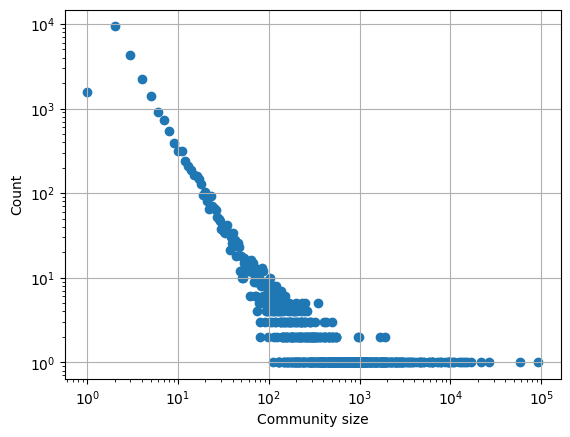

In [ ]:
fig, ax = plt.subplots()

ax.scatter(*zip(*community_size_list))
ax.grid()
ax.set_xlabel("Community size")
ax.set_ylabel("Count")
ax.set_yscale("log")
ax.set_xscale("log")
fig.savefig("D:\\M4R_oskar\\Figures\\loglog_community_size_nonpowerlaw.png", dpi=300, bbox_inches='tight')

### Graph of communities

elbow method to see how many louvain communities to use

In [ ]:
total_users = sum([len(i) for i in sorted_communities])
left_over_nodes = total_users

fraction_for_community = []

# decreasing fraction of users left after communities are removed
for i in sorted_communities:
    fraction_for_community.append(left_over_nodes/total_users)
    left_over_nodes = left_over_nodes - len(i)

In [ ]:
plt.plot(fraction_for_community[0:1000])
plt.xticks(np.linspace(0, 1000, 11))
plt.grid()
plt.xlabel('Community')
plt.ylabel('Fraction of users')
plt.savefig('D:\\M4R_oskar\\Figures\\Fraction_of_users_louvain.png')

graph with only 100 largest communities

In [ ]:
G_weighted_100_largest = G_weighted.copy()
nodes_to_remove = []

# create graph with only 100 largest comms
for i in range(len(sorted_communities) - 100):
  # loop over all communities except 100 largest
  for node in sorted_communities[-(i+1)]:
    # remove nodes
    nodes_to_remove.append(node)

G_weighted_100_largest.remove_nodes_from(nodes_to_remove)

In [ ]:
print(G_weighted_100_largest.number_of_nodes())

614139


In [ ]:
dictionary_of_communities = {}
# for each node indicate which community it is in

sorted_communities_100 = sorted_communities[0:100]

for node in list(G_weighted_100_largest):
  community_of_node = [node in community for community in sorted_communities_100].index(True) + 1
  dictionary_of_communities[node] = community_of_node

In [ ]:
string_dictionary_of_communities = {}
# turn to string

for key, value in dictionary_of_communities.items():
  string_dictionary_of_communities[str(key)] = value

In [ ]:
import json

with open("string_dictionary_of_communities", "w") as fp:
  json.dump(string_dictionary_of_communities, fp)
files.download('string_dictionary_of_communities')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json

string_dictionary_of_communities = json.load('string_dictionary_of_communities')

In [ ]:
community_network = {}
# dictionary where keys are tuples indicating edge between communities and weights are sum of weights of connections of the nodes between these two communities

iter = 0

for node in list(G_weighted_100_largest):
  # over nodes in graph of 100 largest comms
  iter +=1
  if iter % 100000 == 0:
    print(iter)
  community_of_node = dictionary_of_communities[node]
  for neighbor in G_weighted_100_largest.neighbors(node):
    community_of_neighbor = dictionary_of_communities[neighbor]
    if tuple([community_of_node, community_of_neighbor]) not in community_network:
      community_network[tuple([community_of_node, community_of_neighbor])] = G_weighted_100_largest[node][neighbor]['weight']
    else:
      community_network[tuple([community_of_node, community_of_neighbor])] += G_weighted_100_largest[node][neighbor]['weight']

100000
200000
300000
400000
500000
600000


Now we have a dictionary where the key is a tuple indicating the edge and the value is the weight of the edge

Now create a pandas dataframe that we can import into gephi

number of edges is





In [ ]:
print(len(community_network))

6242


In [ ]:
import pandas as pd

# pandas table for use in gephi edges between communities and weights

list_source = []
list_target = []
list_weight = []

for key, value in community_network.items():
  list_source.append(key[0])
  list_target.append(key[1])
  list_weight.append(value)

edges_table_community_network = pd.DataFrame({'Source': list_source, 'Target': list_target, 'Weight': list_weight})

In [ ]:
edges_table_community_network.to_csv('D:\\M4R_oskar\\User_Network\\Communities_Base_Louvain\\edges_table_community_network_100_largest2.csv')

#### Graph of 100 largest louvain community colored by misinformation

In [ ]:
dict_community_misinf = {} # dictionary of misinformation quotients for each community

i = 0
for community in sorted_communities[0:100]:
    i+=1
    print(i)
    print(len(community))
    community_misinf = 0
    community_tweets = 0
    j = 0
    for user in community:
        j+=1
        if j%10000==0:
            print(j)
        try:
            index = user_text_data_misinf2[user_text_data_misinf2['User_ID']==user].index[0]
            community_misinf += user_text_data_misinf2['Misinformation'][index] * len(user_text_data_misinf2['Cleaned_Tweets'][index])
            community_tweets += len(user_text_data_misinf2['Cleaned_Tweets'][index])
            dict_community_misinf[i] = community_misinf/community_tweets
        except IndexError:
            pass

In [ ]:
import pandas as pd

# dataset of community id with corresponding misinformation quotient for gephi
dataset_node_attributes = pd.DataFrame.from_dict(dict_community_misinf, orient='index', columns=['Misinformation'])
dataset_node_attributes['ID'] = range(1,101)
dataset_node_attributes = dataset_node_attributes[['ID', 'Misinformation']]

In [ ]:
dataset_node_attributes.to_csv('D:\\M4R_oskar\\User_Network\\Communities_Base_Louvain\\dataset_node_attributes_100_largest2.csv')

### Pagerank within Louvain communities

In [ ]:
for i in range(10):
  G_community = G_weighted.copy()
  print(G_community.number_of_nodes())
  # remove nodes not in community
  nodes_to_remove = []
  for j in range(len(sorted_communities)):
    if j != i:
      nodes_to_remove.extend([node for node in sorted_communities[j]])
  print(len(nodes_to_remove))
  G_community.remove_nodes_from(nodes_to_remove)
  print(G_community.number_of_nodes())

  pagerank = nx.pagerank(G_community, weight='weight')  # calculate pagerank inside community
  pagerank_list = sorted(list(pagerank.items()), key=lambda x: x[1], reverse=True)
  print(f'{i+1} largest community, {len(sorted_communities[i])} nodes')
  print('Pagerank for 10 most central nodes')
  print(pagerank_list[0:10])
  print('----------------------------------------------')

In [ ]:
# most important users in each community

for user in [1478792963090169860, 850036892, 472777204, 309587728, 1325555226552594432,175420754,337808606,707231479047315456,148529707,455937214]:
    try:
        index = np.where(user_text_data_misinf2['User_ID']==user)[0][0]
        user = str(user)
        print(username[user])
        print(user_text_data_misinf2['Cleaned_Tweets'][index])
        print('----------------------------------------------')
    except IndexError:
        pass

### Geographical analysis of communities

In [ ]:
import json

# dictionary of twitter location names for users
node_geo_data = json.load(open('D:\\M4R_oskar\\User_Network\\user_data_location', 'r'))

print(len(node_geo_data))  # number of position data available

705544


In [ ]:
dict_locations = {}  # dictionary of locations as given by twitter users along with counts

for key in node_geo_data.keys():
    if node_geo_data[key] not in dict_locations.keys():
        dict_locations[node_geo_data[key]] = 1
    else:
        dict_locations[node_geo_data[key]] += 1


dict_locations = {k: v for k, v in sorted(dict_locations.items(), key=lambda item: item[1], reverse=True)}


total dictionary of twitter location names along with counts for all 10 largest communities

In [ ]:
country_dict = {}  # dictionary of location names with counts for 10 largest communities

for i in range(10):
    # loop over 10 largest communities

    for node in sorted_communities[i]:

        if str(node) in node_geo_data:
            #if node has geodata
            country = node_geo_data[str(node)]
            if country not in country_dict:
                country_dict[country] = 1
            else:
                country_dict[country] += 1


country_dict = {k: v for k, v in sorted(country_dict.items(), key=lambda item: item[1], reverse=True)}

#### Get all user location data into same format ie get the corresponding country name

In [ ]:
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="oskarpanek@seznam.cz")  # nominatim API

def getcoordinates(location):
    """
    Given the input location name string generate the geographical position coordinates
    """
    try:
        return geolocator.geocode(location, timeout=1, language='en')
    except GeocoderTimedOut:
        return getcoordinates(location)

def getaddress(coordinates):
    """
    Given the coordinates generate text location
    """
    try:
        return geolocator.reverse(coordinates, timeout=1, language='en')
    except GeocoderTimedOut:
        return getaddress(coordinates)

In [ ]:
with open(f'D:\\M4R_oskar\\User_Network\\Country_lists\\country_dict_list_split_0.pickle', 'rb') as fp:
    country_dict = pickle.load(fp)


country_dict = dict(country_dict)

from geopy.exc import GeocoderUnavailable

location_dict_full = {}
i = 0

for key in list(country_dict.keys()):
    # turn twitter location names into coordinates
    i += 1
    if i % 100 == 0:
        print(i)
    try:
        location = getcoordinates(key)
        latitude = location.latitude
        longitude = location.longitude
        location_dict_full[key] = [latitude, longitude]
    except AttributeError:
        pass
    except GeocoderUnavailable:
        print(key)
        print(i)
        with open('D:\\M4R_oskar\\User_Network\\Location_dict\\location_dict_largest_communities_0.json', 'w') as fp:
            json.dump(location_dict_full, fp)



with open('D:\\M4R_oskar\\User_Network\\Location_dict\\location_dict_largest_communities_0.json', 'w') as fp:
    json.dump(location_dict_full, fp)

import numpy as np

twitter_names = location_dict_full.keys()
coordinates = location_dict_full.values()
location_dict_for_df = {'Twitter_Name': list(twitter_names), 'Coordinates': list(coordinates)}  # dictionary of location names along with coordinates
location_df = pd.DataFrame(location_dict_for_df)

location_df['Country'] = np.nan  # initiate a column with country names

for name in location_df['Twitter_Name']:
    # loop over twitter location names and get corresponding coordinates
    index = location_df.index[location_df['Twitter_Name']==name].tolist()
    coordinates = location_df['Coordinates'].iloc[index].tolist()
    try:
        # get country name from coordinates and add to dataframe
        location = getaddress(coordinates)
        country = location.address.split(",")[-1].strip()
        #print(country)
        location_df['Country'].iloc[index] = country
    except AttributeError:
        pass
    except GeocoderUnavailable:
        pass

location_df.to_csv('D:\\M4R_oskar\\User_Network\\location_df_largest_communities.csv')

#### Choropleth maps

In [ ]:
import pandas as pd
location_df = pd.read_csv('D:\\M4R_oskar\\User_Network\\Location_df\\location_df_largest_communities_full.csv')

In [ ]:
import plotly
import plotly.express as px

def choropleth(community, location_df, list_of_country_dict):
    """
    community: int, number of louvain community
    location_df: dataframe with Twitter_Name, Coordinates and Country
    list_of_country_dict: list of dictionaries, for each community a dictionary with twitter name as key and count as value

    creates choropleth map of the world with color in countries where users belong
    """

    df_largest_community = pd.DataFrame(columns=['Country','Count'])  # country and count dataframe for map
    location_df = location_df.reset_index(drop=True)

    for location in list_of_country_dict[community-1].keys():
        # loop over location for community
        count = list_of_country_dict[community-1][location]

        index = location_df.index[location_df['Twitter_Name']==location]
        if index.size != 0:
            country = location_df['Country'].iloc[index].tolist()[0]

            if len(df_largest_community) == 0:
                # initialise dataframe
                inter_df = pd.DataFrame(columns=['Country','Count'])
                inter_df.at[0,'Country'] = country
                inter_df.at[0,'Count'] = count
                df_largest_community = pd.concat([df_largest_community, inter_df], ignore_index=True)
            else:
                if country not in df_largest_community['Country'].to_list():
                    # country does not yet exist, initialise country
                    inter_df = pd.DataFrame(columns=['Country','Count'])
                    inter_df.at[0,'Country'] = country
                    inter_df.at[0,'Count'] = count
                    df_largest_community = pd.concat([df_largest_community, inter_df], ignore_index=True)
                else:
                    # else add count
                    index = df_largest_community.index[df_largest_community_full['Country']==country]
                    df_largest_community['Count'].iloc[index] += count

    df_largest_community = df_largest_community.sort_values(by=['Count'], ascending=False) # country and count dataframe
    fig = px.choropleth(df_largest_community, locations="Country",color=df_largest_community["Count"].astype(float),
                         locationmode="country names", scope="world",color_continuous_scale = 'ylorrd',
                         labels={'color':'Number of users'})
    fig.show()
    fig.write_html('D:\\M4R_oskar\\Figures\\Choropleth_communities\\Louvain\\choropleth_community_'+str(community)+'.html')

In [ ]:
for i in range(1,11):
    print(f"Choropleth for community {i}")
    choropleth(i, location_df, list_of_country_dict)

Choropleth for community 1


Choropleth for community 2


Choropleth for community 3


Choropleth for community 4


Choropleth for community 5


Choropleth for community 6


Choropleth for community 7


Choropleth for community 8


Choropleth for community 9


Choropleth for community 10


for 10 largest communities all location data with counts

In [ ]:
list_of_country_dict = []

for i in range(len(sorted_communities)):


    country_dict = {}

    for node in sorted_communities[i]:

        if str(node) in node_geo_data:
            country = node_geo_data[str(node)]
            if country not in country_dict:
                country_dict[country] = 1
            else:
                country_dict[country] += 1


    country_dict = {k: v for k, v in sorted(country_dict.items(), key=lambda item: item[1], reverse=True)}

    list_of_country_dict.append(country_dict)

    #print(f"Community {i}:{country_dict}")

print(len(list_of_country_dict))


unique_keys = set().union(*(d.keys() for d in list_of_country_dict))
print(len(unique_keys))


25978
182575


dictionary for entire dataset, twitter location names with counts

In [ ]:
country_dict_full = {}

for i in range(len(sorted_communities)):


    for node in sorted_communities[i]:
        if str(node) in node_geo_data:
          #if location data is available
            country = node_geo_data[str(node)]
            if country not in country_dict_full:
              # if new country not in dict initialize count
                country_dict_full[country] = 1
            else:
                country_dict_full[country] += 1


country_dict_full = {k: v for k, v in sorted(country_dict_full.items(), key=lambda item: item[1], reverse=True)}

print(len(country_dict_full))

182575


In [ ]:

for key in country_dict.keys():
    if key in country_dict_full.keys():
        del country_dict_full[key]

print(len(country_dict))
print(len(country_dict_full))

56700
125875


#### Choropleth map for whole network

In [ ]:
df_largest_community_full = pd.DataFrame(columns=['Country','Count'])  # dataframe of countries and counts for full network
location_df = location_df.reset_index(drop=True)

for community in range(1,len(list_of_country_dict)+1):
    # loop over communities
    for location in list_of_country_dict[community-1].keys():
        # loop over locations in communities
        count = list_of_country_dict[community-1][location]
        index = location_df.index[location_df['Twitter_Name']==location]
        if index.size != 0:
            # if location data exists
            country = location_df['Country'].iloc[index].tolist()[0]
            if len(df_largest_community_full) == 0:
                # initialise dataframe
                inter_df = pd.DataFrame(columns=['Country','Count'])
                inter_df.at[0,'Country'] = country
                inter_df.at[0,'Count'] = count
                df_largest_community_full = pd.concat([df_largest_community_full, inter_df], ignore_index=True)
            else:
                if country not in df_largest_community_full['Country'].to_list():
                    # initialise country
                    inter_df = pd.DataFrame(columns=['Country','Count'])
                    inter_df.at[0,'Country'] = country
                    inter_df.at[0,'Count'] = count
                    df_largest_community_full = pd.concat([df_largest_community_full, inter_df], ignore_index=True)
                else:
                    # add count to existing country
                    index = df_largest_community_full.index[df_largest_community_full['Country']==country]
                    df_largest_community_full['Count'].iloc[index] += count

df_largest_community_full = df_largest_community_full.sort_values(by=['Count'], ascending=False)


In [ ]:
print(df_largest_community_full.head())

           Country   Count
0    United States  218926
3   United Kingdom   44151
1           Canada   25504
2        Australia   10731
13           India    9517


In [ ]:
# same search as before but for entire network location information this time

from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
import pickle
import json
import pandas as pd
from geopy.exc import GeocoderServiceError
geolocator = Nominatim(user_agent="pinda@seznam.cz")

def getcoordinates(location):
    try:
        return geolocator.geocode(location, timeout=1, language='en')
    except GeocoderTimedOut:
        return getcoordinates(location)

def getaddress(coordinates):
    try:
        return geolocator.reverse(coordinates, timeout=1, language='en')
    except GeocoderTimedOut:
        return getaddress(coordinates)


with open('D:\\M4R_oskar\\User_Network\\country_dict_full_split_0.pickle', 'rb') as fp:
    country_dict = pickle.load(fp)


country_dict = dict(country_dict)

from geopy.exc import GeocoderUnavailable

location_dict_full = {}
i = 0

for key in list(country_dict.keys()):
    i += 1
    if i % 100 == 0:
        #print(i)
    try:
        location = getcoordinates(key)
        latitude = location.latitude
        longitude = location.longitude
        location_dict_full[key] = [latitude, longitude]
    except AttributeError:
        pass
    except GeocoderUnavailable:
        #print(key)
        #print(i)
    except GeocoderServiceError:
        #print(i)



with open('D:\\M4R_oskar\\User_Network\\location_dict_full_0.json', 'w') as fp:
    json.dump(location_dict_full, fp)


import numpy as np

twitter_names = location_dict_full.keys()
coordinates = location_dict_full.values()
location_dict_for_df = {'Twitter_Name': list(twitter_names), 'Coordinates': list(coordinates)}
location_df = pd.DataFrame(location_dict_for_df)

location_df['Country'] = np.nan
#print(location_df.head())


i = 0
for name in location_df['Twitter_Name']:
    index = location_df.index[location_df['Twitter_Name']==name].tolist()
    coordinates = location_df['Coordinates'].iloc[index].tolist()
    i += 1
    if i % 100 == 0:
        print(i)
    try:
        location = getaddress(coordinates)
        country = location.address.split(",")[-1].strip()
        #print(country)
        location_df['Country'].iloc[index] = country
    except AttributeError:
        pass
    except GeocoderUnavailable:
        #print(i)
        #print(coordinates)
    except GeocoderServiceError:
        #print(i)


location_df.to_csv('D:\\M4R_oskar\\User_Network\\location_df_full.csv')

choropleth for full network

In [ ]:
df_full = pd.DataFrame(columns=['Country','Count'])  # dataframe for choropleth
location_df_full = location_df_full.reset_index(drop=True)

for location in country_dict_full.keys():
    # loop over location
    count = country_dict_full[location]
    index = location_df_full.index[location_df_full['Twitter_Name']==location]
    if index.size != 0:
        # if location exists
        country = location_df_full['Country'].iloc[index].tolist()[0]

        if len(df_full) == 0:
            # if dataframe empty initialise
            inter_df = pd.DataFrame(columns=['Country','Count'])
            inter_df.at[0,'Country'] = country
            inter_df.at[0,'Count'] = count
            df_full = pd.concat([df_full, inter_df], ignore_index=True)
        else:
            if country not in df_full['Country'].to_list():
                # initialise country entry
                inter_df = pd.DataFrame(columns=['Country','Count'])
                inter_df.at[0,'Country'] = country
                inter_df.at[0,'Count'] = count
                df_full = pd.concat([df_full, inter_df], ignore_index=True)
            else:
                # add count
                index = df_full.index[df_full['Country']==country]
                df_full['Count'].iloc[index] += count

df_full = df_full.sort_values(by=['Count'], ascending=False)
fig = px.choropleth(df_full, locations="Country",color=df_full["Count"].astype(float),
                        locationmode="country names", scope="world",color_continuous_scale = 'ylorrd',
                        labels={'color':'Number of users'})
fig.show()
fig.write_html('D:\\M4R_oskar\\Figures\\Choropleth_communities\\Louvain\\choropleth_full_network_lcc.html')

## Infomap partitioning

create a dict of user id to assigned number so that we can use it in infomap as infomap does not allow node values with large numbers which happens with user_ids

In [ ]:
import pandas as pd

nodes_list = list(G_weighted.nodes)
nodes_label_list = list(range(1, len(nodes_list)+1))  # nodes have labels 1,..., number of nodes
nodes_dict = dict(zip(nodes_list, nodes_label_list))
node_to_userid_dict = dict(zip(nodes_label_list, nodes_list))

In [ ]:
infomap_graph = infomap.Infomap()
i=0

for edge in G_weighted.edges():
    # turn G_weighted into infomap graph
    i+=1
    if i%1000000==0:
        print(i)
    source = nodes_dict[edge[0]]
    target = nodes_dict[edge[1]]
    weight = G_weighted[edge[0]][edge[1]]['weight']
    infomap_graph.add_link(source, target, weight)

1000000
2000000
3000000
4000000


now run infomap algorithm on graph and collect resulting communities

In [ ]:
infomap_graph.run()  # run infomap algorithm

In [ ]:
tree = infomap_graph.tree  # get the resulting tree

In [ ]:
list_modules = [[] for i in range(74)]  # communities resulting from infomap

for node,module in infomap_graph.getModules().items():
	#loop over all nodes of graph and associated community
	user_id = node_to_userid_dict[node]
	list_modules[module-1].append(user_id)

module_sizes = [len(i) for i in list_modules]

print(module_sizes)
print(len(list_modules))

[676848, 195390, 86610, 28005, 12164, 7737, 2537, 3078, 2992, 1933, 2176, 1270, 1510, 1128, 1178, 924, 1437, 719, 617, 714, 597, 472, 631, 349, 322, 325, 378, 126, 289, 216, 107, 110, 169, 103, 164, 87, 84, 30, 88, 28, 18, 22, 32, 46, 33, 43, 26, 52, 36, 41, 11, 39, 14, 17, 17, 37, 11, 12, 26, 18, 27, 27, 9, 24, 6, 7, 7, 8, 7, 5, 6, 6, 3, 2]
74


In [ ]:
sorted_communities_infomap = sorted(list_modules, key=len, reverse=True)

with open('D:\\M4R_oskar\\User_Network\\Communities_Infomap\\sorted_communities_infomap.pickle', 'wb') as fp:
    pickle.dump(sorted_communities_infomap, fp)

### Performance measures of Infomap

In [ ]:
with open('D:\\M4R_oskar\\User_Network\\Communities_Infomap\\sorted_communities_infomap.pickle', 'rb') as fp:
    sorted_communities_infomap = pickle.load(fp)

In [ ]:
print(nx.community.modularity(G_weighted, sorted_communities_infomap))
print(nx.algorithms.community.quality.coverage(G_weighted, sorted_communities_infomap))

### Pagerank in Infomap communities

In [ ]:
for i in range(3):
  G_community = G_weighted.copy()
  #print(G_community.number_of_nodes())
  nodes_to_remove = []
  for j in range(len(sorted_communities_infomap)):
    if j != i:
      nodes_to_remove.extend([node for node in sorted_communities_infomap[j]])
  #print(len(nodes_to_remove))
  G_community.remove_nodes_from(nodes_to_remove)
  #print(G_community.number_of_nodes())
  pagerank = nx.pagerank(G_community, weight='weight')
  pagerank_list = sorted(list(pagerank.items()), key=lambda x: x[1], reverse=True)
  if i == 0:
    # first community
    for user in pagerank_list[0:10]:
      index = np.where(user_text_data_misinf2['User_ID']==user[0])[0][0]
      print(f"{username[str(user[0])]}: {user_text_data_misinf2['Misinformation'][index]}")
      print(user_text_data_misinf2['Cleaned_Tweets'][index])
  elif i == 1:
    # second community
    for user in pagerank_list[0:10]:
      index = np.where(user_text_data_misinf2['User_ID']==user[0])[0][0]
      print(f"{username[str(user[0])]}: {user_text_data_misinf2['Misinformation'][index]}")
      print(user_text_data_misinf2['Cleaned_Tweets'][index])
  elif i == 2:
    # third community
    for user in pagerank_list[0:10]:
      try:
        index = np.where(user_text_data_misinf2['User_ID']==user[0])[0][0]
        print(f"{username[str(user[0])]}: {user_text_data_misinf2['Misinformation'][index]}")
        print(user_text_data_misinf2['Cleaned_Tweets'][index])
      except IndexError:
        pass
  print(f'{i+1} largest community, {len(sorted_communities_infomap[i])} nodes')
  print('Pagerank for 10 most central nodes')
  print(pagerank_list[0:10])
  print('----------------------------------------------')

### Misinformation in infomap communities

In [ ]:
misinf_quotient_community_infomap = []  # misinformation quotient for infomap communities

for i in range(len(list_modules)):
    # loop over communities
    community = list_modules[i] # current community
    total_misinf = 0
    total_tweets = 0
    for user in community:
        try:
            # if user is an original tweeter
            index = np.where(user_text_data_misinf2['User_ID']==user)[0][0]  # index of user
            total_misinf += user_text_data_misinf2['Misinformation'][index] * len(user_text_data_misinf2['Cleaned_Tweets'][index]) # update total tweets containing misinformation
            total_tweets += len(user_text_data_misinf2['Cleaned_Tweets'][index])  # update total tweets
        except IndexError:
            pass
    if total_tweets == 0:
        misinf_quotient_community_infomap.append(0)
    else:
        misinf_quotient_community_infomap.append(total_misinf/total_tweets)  # append misinf quotient

print(misinf_quotient_community_infomap)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
[0.5104149890120268, 0.29475449733716136, 0.259810896484057, 0.32425179677249116, 0.24254642787830016, 0.250997281364755, 0.12813055664855688, 0.37358107701200105, 0.0, 0.1377014097903604, 0.2827285549429414, 0.23487788275880986, 0.21273784098531331, 0.14666169761033565, 0.339684871528978, 0.3291403615106208, 0.21183890431324867, 0.21667851606944158, 0.0, 0.24743477323576024, 0.19234800838574423, 0.10202155158927494, 0.0, 0.004247084841174105, 0.10295628082978579, 0.26400949919716843, 0.3903948143783147, 0.3994725968019737, 0.0, 0.3238962125967776, 0.019186420173150354, 0.5188269998264793, 0.2616822429906542, 0.1306878306878307, 0.0, 0.4855597170203912, 0.0, 0.0, 0, 0.3595032840722496, 0.17054263565891473, 0.30333478957332166, 0.7, 0.3323045267489712, 0.7699115044247787, 0.596

## Comparing Infomap and Louvain

In [ ]:
sorted_communities_louvain = pickle.load(open('D:\\M4R_oskar\\User_Network\\Communities_Base_Louvain\\base_louvain_sorted_communities.pickle', 'rb'))

In [ ]:
dict_labels_infomap = {}  # for all users get corresponding infomap community label

for i in range(len(list_modules)):
  # loop over infomap communties
    for user in list_modules[i]:
        # loop over users in community
        dict_labels_infomap[user] = i+1

dict_labels_louvain = {}  # for all users get corresponding louvain community label

for i in range(len(sorted_communities_louvain)):
   # loop over louvain communities
    for user in sorted_communities_louvain[i]:
      # loop over users in community
        dict_labels_louvain[user] = i+1

print(len(dict_labels_infomap))
print(len(dict_labels_louvain))

community_labels_infomap = []
community_labels_louvain = []

for node in G_weighted.nodes():
    community_labels_infomap.append(dict_labels_infomap[node])
    community_labels_louvain.append(dict_labels_louvain[node])

1034337
1034337


In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# ari score for louvain and infomap communities
print(adjusted_rand_score(community_labels_infomap, community_labels_louvain))